In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from helpers.collection_of_experiments import CollectionOfExperiments
from helpers.computational_tools import remesh, select_LatLon, Lk_error, x_coord, y_coord
from helpers.plot_helpers import *
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")

In [2]:
ds = CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Feb2022/bare', additional_subfolder='output')

In [3]:
ds.remesh('R64', 'R4')

Experiment R64 coarsegrained to R4 is created. Its identificator=R64_R4


In [4]:
ds.exps

['R16', 'R2', 'R32', 'R4', 'R64', 'R8', 'R64_R4']

# Check functions computing KE and PE

## KE

In [27]:
KE_ref = ds['R2'].series.KE

In [28]:
KE = ds['R2'].KE_joul_series

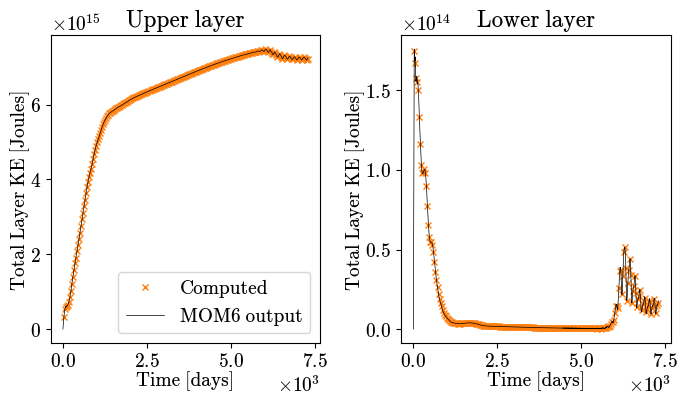

In [29]:
default_rcParams()

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
KE.isel(zl=0).plot(ls='', marker='x', markersize=5, color='tab:orange', label='Computed')
KE_ref.isel(Layer=0).plot(color='k', lw=0.5, label='MOM6 output')
plt.legend()
plt.title('Upper layer')

plt.subplot(1,2,2)
KE.isel(zl=1).plot(ls='', marker='x', markersize=5, color='tab:orange', label='computed')
KE_ref.isel(Layer=1).plot(color='k', lw=0.5, label='MOM6 output')
plt.title('Lower layer')

plt.savefig('KE_accuracy.pdf')

In [31]:
R = ds['R2'].vert_grid.R
KE_ref = KE_ref.rename({'Layer' : 'zl'})

Text(0.5, 1.0, 'Note, in definition of \n KE the reference \ndensity is used')

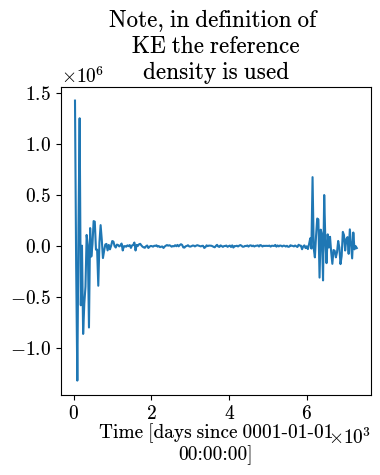

In [36]:
(KE*R.isel(zl=0)/R.isel(zl=1) - KE_ref.interp(Time=KE.Time)).isel(zl=1).plot()
plt.title('Note, in definition of \n KE the reference \ndensity is used')

Text(0.5, 1.0, '')

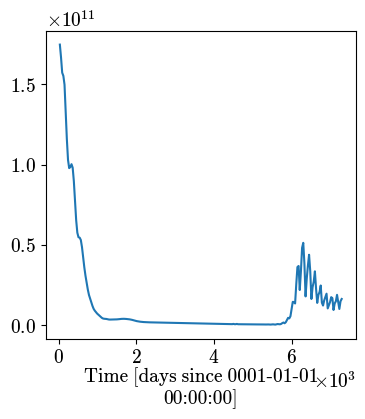

In [37]:
(KE - KE_ref.interp(Time=KE.Time)).isel(zl=1).plot()
plt.title('')

## APE internal interface

In [38]:
PE = ds['R2'].PE_joul_series
PE_ref = ds['R2'].series.APE.isel(Interface=1)

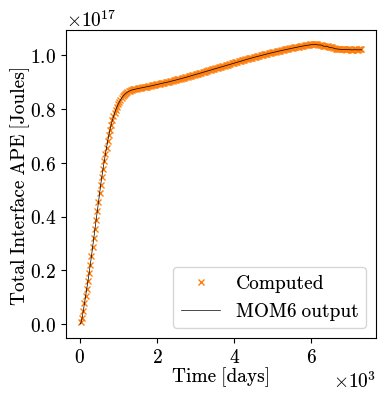

In [39]:
default_rcParams()

plt.figure(figsize=(4,4))
PE.plot(ls='', marker='x', markersize=5, color='tab:orange', label='Computed')
PE_ref.plot(color='k', lw=0.5, label='MOM6 output')
plt.legend()
#plt.yscale('log')
#plt.ylim([0.8e17,1.2e+17])
plt.title('')

plt.savefig('PE_accuracy.pdf')

Text(0.5, 1.0, 'Note, in definition of \n APE the reference \ndensity is used')

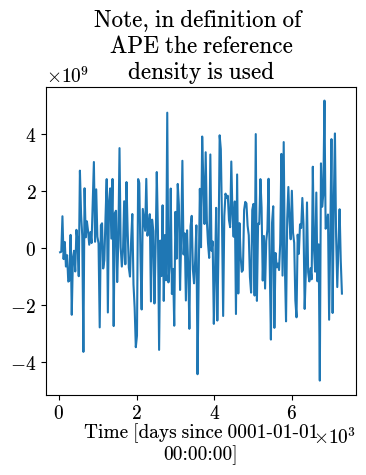

In [50]:
(PE * R.isel(zl=0)/R.isel(zl=1) - PE_ref.interp(Time=PE.Time)).plot()
plt.title('Note, in definition of \n APE the reference \ndensity is used')

Text(0.5, 1.0, '')

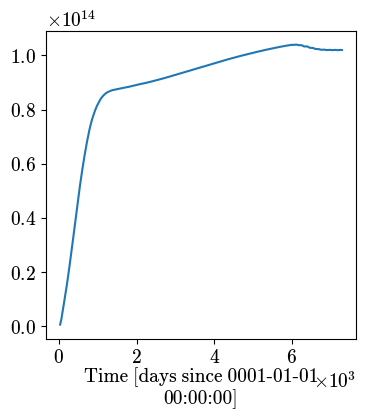

In [49]:
(PE - PE_ref.interp(Time=PE.Time)).plot()
plt.title('')

## APE free surface

In [51]:
PE_ssh = ds['R2'].PE_ssh_series
PE_ssh_ref = ds['R2'].series.APE.isel(Interface=0)

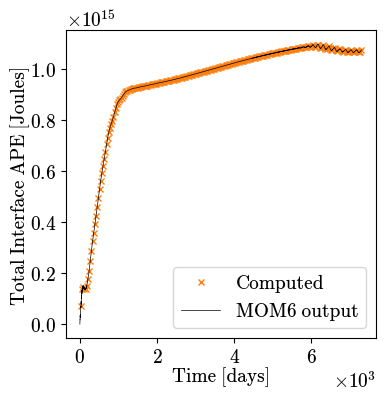

In [58]:
default_rcParams()

plt.figure(figsize=(4,4))
PE_ssh.plot(ls='', marker='x', markersize=5, color='tab:orange', label='Computed')
PE_ssh_ref.plot(color='k', lw=0.5, label='MOM6 output')
plt.legend()
plt.title('')

plt.savefig('PE_ssh_accuracy.pdf')

Text(0.5, 1.0, '')

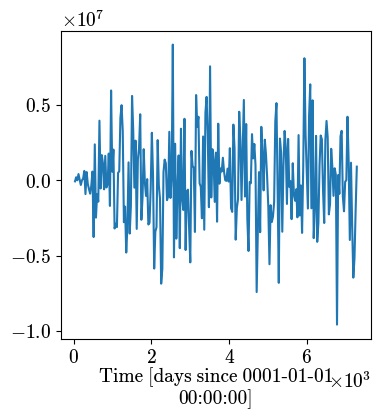

In [59]:
(PE_ssh - PE_ssh_ref.interp(Time=PE_ssh.Time)).plot()
plt.title('')

# plotter

In [53]:
def plot_KE_PE(ds, exps=['R4', 'R8', 'R64_R4'], labels=['$1/4^o$', '$1/8^o$', '$1/64^o$ \n coarsegrained \n  to $1/4^o$'], color=['k', 'tab:cyan', 'tab:blue', 'tab:red']):
    plt.figure(figsize=(9,9))
    plt.subplots_adjust(wspace=0.4, hspace=0.6)
    width = (len(exps)-1) * [0.4] + [1]
    for zl in range(2):
        plt.subplot(2,2,zl+1)
        MKE = []
        EKE = []
        for exp in exps:          
            MKE.append(1e-15*ds[exp].MKE_joul.isel(zl=zl).values)
            EKE.append(1e-15*ds[exp].EKE_joul.isel(zl=zl).values)
        x=np.arange(len(exps));
        x[-1] += 1.5
        plt.bar(x,MKE,width,label='MKE',color=color[0])
        plt.bar(x,EKE,width,bottom=MKE,label='EKE',color=color[1])
        plt.ylabel('Kinetic energy, PJ', fontsize=14);
        plt.xticks(ticks=x,labels=labels);
        if zl==0:
            plt.title('KE, Upper layer')
        else:
            plt.title('KE, Lower layer')
        plt.legend(loc='upper left', fontsize=14)
        plt.ylim([0, (EKE[-1]+MKE[-1])*(1.55-zl/2)])
        
    plt.subplot(2,2,3)
    MPE = []
    EPE = []
    for exp in exps:
        MPE.append(1e-15*ds[exp].MPE_joul.values)
        EPE.append(1e-15*ds[exp].EPE_joul.values)     
    x=np.arange(len(exps));
    x[-1] += 1.5
    plt.bar(x,MPE,width,label='MPE',color=color[2])
    plt.bar(x,EPE,width,bottom=MPE,label='EPE',color=color[3])
    plt.ylabel('Interface displacement \n potential energy, PJ', fontsize=14);
    plt.xticks(ticks=x,labels=labels);
    plt.title('Potential energy')
    plt.legend(loc='upper left', fontsize=14)
    plt.ylim([0, (EPE[-1]+MPE[-1])*1.8])
    plt.axhline(y=MPE[-1], ls=':', color=color[2])
    
    plt.subplot(2,2,4)
    EKE = []
    for exp in exps:          
        EKE.append(1e-15*ds[exp].EKE_joul.values.sum())
    x=np.arange(len(exps));
    x[-1] += 1.5
    plt.bar(x,EKE,width,label='EKE',color=color[1])
    plt.bar(x,EPE,width,bottom=EKE, label='EPE',color=color[3])
    plt.ylabel('Eddy energy, PJ', fontsize=14)
    plt.title('Energy of eddies')
    plt.xticks(ticks=x,labels=labels);
    plt.legend(loc='upper left', fontsize=14)
    plt.ylim([0, (EKE[-1]+EPE[-1])*1.4])


# Smagorinsky

In [11]:
ds += CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Apr2022/R4/Smagorinsky', additional_subfolder='output')

In [12]:
ds.exps

['R16',
 'R2',
 'R32',
 'R4',
 'R64',
 'R8',
 'R64_R4',
 'Cs-0.001',
 'Cs-0.002',
 'Cs-0.005',
 'Cs-0.01',
 'Cs-0.02',
 'Cs-0.03',
 'Cs-0.04',
 'Cs-0.05',
 'Cs-0.06',
 'Cs-0.07',
 'Cs-0.08',
 'Cs-0.09',
 'Cs-0.1']

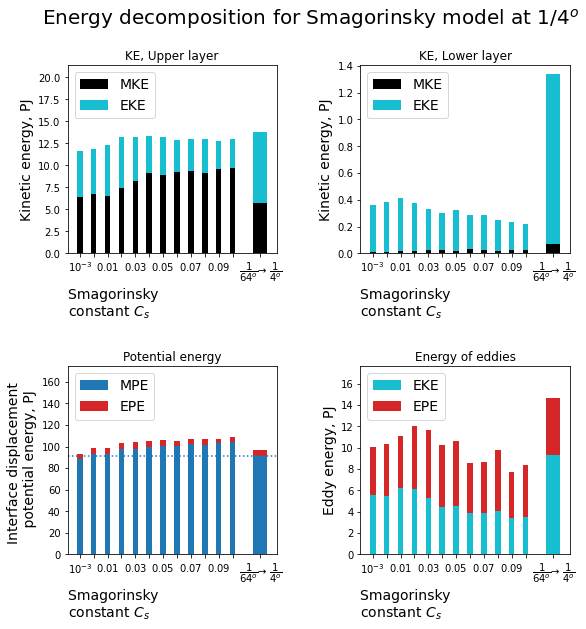

In [34]:
plot_KE_PE(ds, 
           exps = ['Cs-0.001', 'Cs-0.002']+[f'Cs-{i/100}' for i in range(1,11)]+['R64_R4'], 
           labels = ['$10^{-3}$', None]+[f'${i/100}$' if i%2==1 else None for i in range(1,11)]+['$\\dfrac{1}{64^o} \\to$ $\\dfrac{1}{4^o}$'],
           color=['k', 'tab:cyan', 'tab:blue', 'tab:red'] 
          )
for j in range(1,5):
    plt.subplot(2,2,j)
    plt.xlabel('Smagorinsky \nconstant $C_s$', loc='left', fontsize=14)
plt.suptitle('Energy decomposition for Smagorinsky model at $1/4^o$', y=0.97, fontsize=20)
plt.savefig('KE-APE-Smagorinsky.pdf',bbox_inches='tight')

In [7]:
def error(exp, target='R64_R4'):
    return sum(ds[exp].L1_error(ds[target], features=['MKE_joul', 'EKE_joul', 'MPE_joul', 'EPE_joul'])[0])

In [218]:
for i in range(1,11):
    print(f'Cs={i/100}, error=', error(f'Cs-{i/100}'))

Cs=0.01, error= 2.0029704278058604
Cs=0.02, error= 2.2884986967721987
Cs=0.03, error= 2.544803043631141
Cs=0.04, error= 2.652486491167749
Cs=0.05, error= 2.746871818417147
Cs=0.06, error= 2.738147591803515
Cs=0.07, error= 2.8699968220335843
Cs=0.08, error= 2.8798120257129574
Cs=0.09, error= 3.073965784293409
Cs=0.1, error= 2.9993501428155755


In [8]:
error('Cs-0.005')

2.2418075493235836

In [9]:
error('Cs-0.002')

2.1694234382228474

In [10]:
error('Cs-0.001')

2.2039678948195314

# Model with low eddy-viscosity does not look like a noise model
Moreover, there is no a stationary eddy in the flow

In [13]:
def plotter(i, exps=['Cs-0.001', 'R64_R4'], labels=['Smagorinsky $C_s=0.001$', 'Hires']):
    ncol = len(exps)
    plt.figure(figsize=(4*ncol,8))
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    for col, exp in enumerate(exps):
        v = ds[exp].velocity
        plt.subplot(2,ncol,1+col)
        imshow(v.isel(zl=0,Time=i), cmap='inferno', vmax = 0.3, cbar=False)
        plt.title(labels[col], fontsize=20)
        plt.subplot(2,2,ncol+1+col)
        imshow(v.isel(zl=1,Time=i), cmap='inferno', vmax=0.1, cbar=False)
    plt.subplot(2,2,1)
    plt.ylabel('Upper layer', fontsize=30)
    plt.subplot(2,2,3)
    plt.ylabel('Lower layer', fontsize=30)

In [14]:
create_animation(plotter, range(243), 'Smag-vs-Hires-0.001.gif')

Animation at FPS=18 will last for 13.5 seconds


In [18]:
def plotter_PV(i, exps=['Cs-0.001', 'R64_R4'], labels=['Smagorinsky $C_s=0.001$', 'Hires']):
    ncol = len(exps)
    plt.figure(figsize=(4*ncol,8))
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    for col, exp in enumerate(exps):
        PV = ds[exp].PV
        plt.subplot(2,ncol,1+col)
        imshow(PV.isel(zl=0,Time=i), cmap='seismic', cbar=False, vmin=0,vmax=2e-7)
        plt.title(labels[col], fontsize=20)
        plt.subplot(2,2,ncol+1+col)
        imshow(PV.isel(zl=1,Time=i), cmap='seismic', cbar=False, vmin=0,vmax=2e-7)
    plt.subplot(2,2,1)
    plt.ylabel('Upper layer', fontsize=30)
    plt.subplot(2,2,3)
    plt.ylabel('Lower layer', fontsize=30)

In [19]:
create_animation(plotter_PV, range(243), 'Smag-vs-Hires-PV-0.001.gif')


Animation at FPS=18 will last for 13.5 seconds


In [20]:
def plotter_RV(i, exps=['Cs-0.001', 'R64_R4'], labels=['Smagorinsky $C_s=0.001$', 'Hires']):
    ncol = len(exps)
    plt.figure(figsize=(4*ncol,8))
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    for col, exp in enumerate(exps):
        RV = ds[exp].RV_f
        plt.subplot(2,ncol,1+col)
        imshow(RV.isel(zl=0,Time=i), cbar=False, cmap='bwr', vmin=-0.2,vmax=0.2)
        plt.title(labels[col], fontsize=20)
        plt.subplot(2,2,ncol+1+col)
        imshow(RV.isel(zl=1,Time=i), cbar=False, cmap='bwr', vmin=-0.2,vmax=0.2)
    plt.subplot(2,2,1)
    plt.ylabel('Upper layer', fontsize=30)
    plt.subplot(2,2,3)
    plt.ylabel('Lower layer', fontsize=30)

In [22]:
create_animation(plotter_RV, range(210,243), 'Smag-vs-Hires-RV-0.001.gif')

Animation at FPS=18 will last for 1.8333333333333333 seconds


In [41]:
# fig, ax = ds.get_axes(2, ncol=2, size=6, ratio=1.3)
# ds.plot_KE_spectrum(['Cs-0.001', 'Cs-0.01', 'Cs-0.1', 'R64_R4'], ax=ax)

# Smagorinsky-ZB

In [42]:
ds += CollectionOfExperiments.init_folder('/scratch/pp2681/mom6/Apr2022/R4/Smagorinsky-ZB', additional_subfolder='output')

In [43]:
ds.exps

['R16',
 'R2',
 'R32',
 'R4',
 'R64',
 'R8',
 'R64_R4',
 'Cs-0.001',
 'Cs-0.002',
 'Cs-0.005',
 'Cs-0.01',
 'Cs-0.02',
 'Cs-0.03',
 'Cs-0.04',
 'Cs-0.05',
 'Cs-0.06',
 'Cs-0.07',
 'Cs-0.08',
 'Cs-0.09',
 'Cs-0.1',
 'Cs-0.01-ZB-0-24',
 'Cs-0.01-ZB-1-24',
 'Cs-0.01-ZB-10-24',
 'Cs-0.01-ZB-2-24',
 'Cs-0.01-ZB-3-24',
 'Cs-0.01-ZB-4-24',
 'Cs-0.01-ZB-5-24',
 'Cs-0.01-ZB-6-24',
 'Cs-0.01-ZB-7-24',
 'Cs-0.01-ZB-8-24',
 'Cs-0.01-ZB-9-24',
 'Cs-0.02-ZB-0-24',
 'Cs-0.02-ZB-1-24',
 'Cs-0.02-ZB-10-24',
 'Cs-0.02-ZB-2-24',
 'Cs-0.02-ZB-3-24',
 'Cs-0.02-ZB-4-24',
 'Cs-0.02-ZB-5-24',
 'Cs-0.02-ZB-6-24',
 'Cs-0.02-ZB-7-24',
 'Cs-0.02-ZB-8-24',
 'Cs-0.02-ZB-9-24',
 'Cs-0.03-ZB-0-24',
 'Cs-0.03-ZB-1-24',
 'Cs-0.03-ZB-10-24',
 'Cs-0.03-ZB-2-24',
 'Cs-0.03-ZB-3-24',
 'Cs-0.03-ZB-4-24',
 'Cs-0.03-ZB-5-24',
 'Cs-0.03-ZB-6-24',
 'Cs-0.03-ZB-7-24',
 'Cs-0.03-ZB-8-24',
 'Cs-0.03-ZB-9-24',
 'Cs-0.04-ZB-0-24',
 'Cs-0.04-ZB-1-24',
 'Cs-0.04-ZB-10-24',
 'Cs-0.04-ZB-2-24',
 'Cs-0.04-ZB-3-24',
 'Cs-0.04-ZB-4-24',
 '

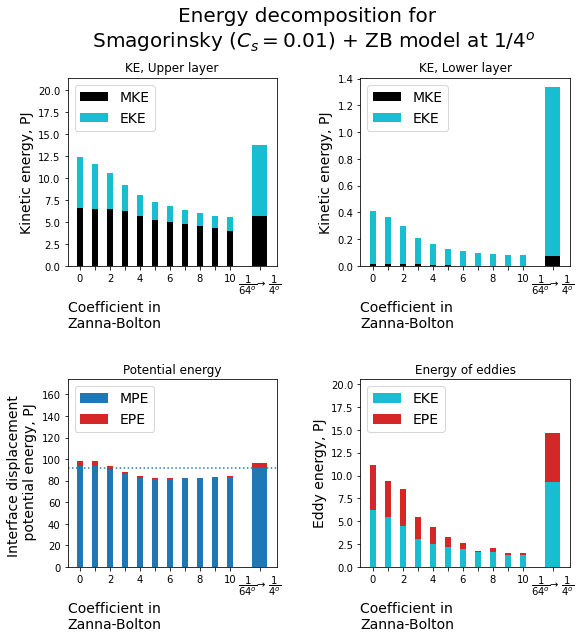

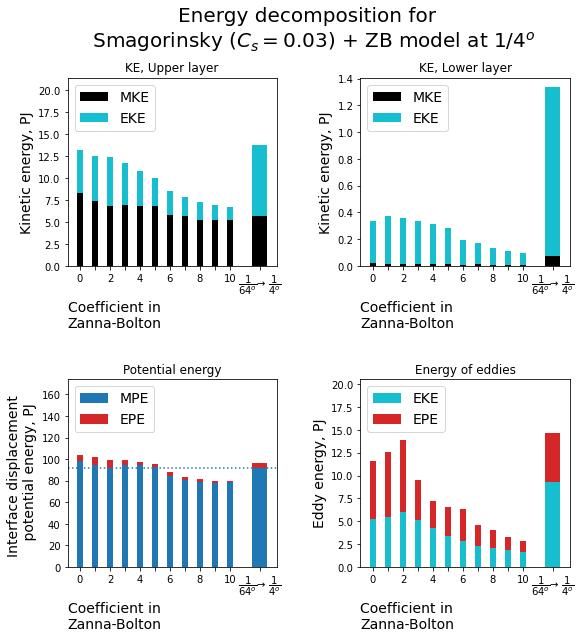

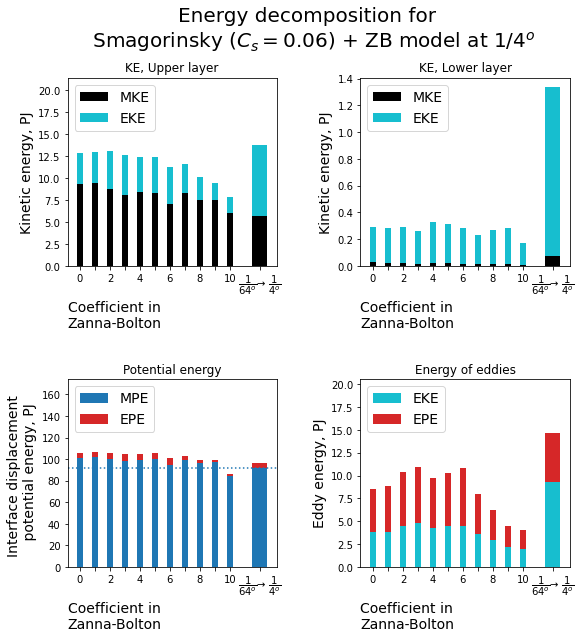

In [66]:
for Cs in [0.01, 0.03, 0.06]:
    plot_KE_PE(ds, 
               exps=[f'Cs-{Cs}-ZB-{i}-24' for i in range(11)] +['R64_R4'], 
               labels = [f'{i}' if i%2==0 else None for i in range(11)]+['$\\dfrac{1}{64^o} \\to$ $\\dfrac{1}{4^o}$'],
              )
    for j in range(1,5):
        plt.subplot(2,2,j)
        plt.xlabel('Coefficient in \nZanna-Bolton', loc='left', fontsize=14)
    plt.suptitle(f'Energy decomposition for \n Smagorinsky ($C_s={Cs}$) + ZB model at $1/4^o$', y=0.99, fontsize=20)
    plt.savefig(f'KE-APE-Smagorinsky-{Cs}-ZB.pdf',bbox_inches='tight')